In [1]:
# function to reshape features into (samples, time steps, features)
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def gen_sequence(id_df, seq_length, seq_cols):
    # Only sequences that meet the window-length are considered, no padding is used. This means for testing
    # we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    # we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

    # function to generate labels


def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)


# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)


# Gradient Solvers for FSVRG in aggregation shape (d,N
def compute_gradient_FSVRG(w, X, Y, lambda_):
    # returns a matrix of shape (d, N)
    N, d = X.shape
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)

    return YX_neg.reshape(d, N) + 2 * lambda_ * w  # (d, N)


# Gradient Solvers
def compute_gradient(w, X, Y, lambda_):
    # returns a vector of shape w.shape, with gradients of w
    N = X.shape[0]
    L = hinge_loss(w, X, Y).flatten()
    YX_neg = -Y * X  # (N, d)
    YX_neg[L == 0, :] = 0
    g = np.sum(YX_neg, axis=0, keepdims=1)
    g = g.T / N

    reg = 2 * lambda_ * w
    #     set_trace()

    return g + reg


# Compute hingeloss
def hinge_loss(w, X, Y):
    # returns the hinge loss for each datapoint in (X,Y) as a vector (N,1)
    (N, d) = X.shape
    assert w.shape == (d, 1)
    assert Y.shape == (N, 1)
    L = 1 - Y * (X @ w)  # (N,1)
    L[L < 0] = 0
    return L


# Cost
def cost(w, X, Y):
    return np.sum(hinge_loss(w, X, Y))


# Predict
def predict(w, X):
    return np.sign(X @ w)


# Accuracy
def accuracy(w, X, Y):
    N = X.shape[0]
    preds = predict(w, X)
    corrects = np.sum(preds == Y)
    return corrects / N


# Def solver
def solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
           mini_batch=100, mem=False, return_cost=False, verbose=True, seed=-1,
           p_val=0, R_val=0, iter_print=False, T_FSVRG=1):
    N_workers = len(X)
    N_workers, N, dw = np.shape(X)
    dw = w.shape[0]

    noise_std = R_val ** 0.5

    if seed != -1:
        np.random.seed(seed)

    cost_ = np.zeros(num_iters + 1)
    acc_ = np.zeros(num_iters + 1)

    if return_cost:
        cost_[0] = cost(w, X_test, Y_test)  # return the first element in cost
        acc_[0] = accuracy(w, X_test, Y_test)  # Return the first element in accuracy

    if (optimizer == "GD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            if iter_print:
                print("..... num_iters =", i, "......")
            for worker_i in range(N_workers):
                #                 set_trace()
                gi = compute_gradient(w, X[worker_i], Y[worker_i], lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # , size=(dw, 1)
                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g / N_workers  # GD update

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

        if (verbose):
            print("GD: Number of iterations: ", num_iters, "/", num_iters)
            print("GD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "SGD"):
        g_ = np.zeros(shape=(dw, N_workers))
        for i in range(num_iters):
            if iter_print:
                print("..... num_iters_SGD =", i, "......")
            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                i_ = int(N * np.random.rand(1))
                X_ = X[worker_i][[i_], :]
                Y_ = Y[worker_i][[i_], :]

                gi = compute_gradient(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # , size=(dw, 1)

                g_[:, worker_i] = gi.flatten()
            g = np.sum(g_, axis=1, keepdims=1)
            w = w - alpha * g / N_workers  # SGD update

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

        if (verbose):
            print("SGD: Number of iterations: ", num_iters, "/", num_iters)
            print("SGD: final norm: ", np.linalg.norm(g))


    elif (optimizer == "FSVRG"):
        T = T_FSVRG
        # epoch length
        K = math.floor(num_iters / T)
        # number of epochs, given number of iteration
        if K == 0:
            # only run for one epoch consisting of num_iters iterations
            K = 1
            T = num_iters

        # Aggregation of all gradients from the workes
        G_vec = np.zeros(shape=(dw, N))  # (d, N)
        w_k = np.zeros(shape=(dw, N_workers))  # (d, N_workers)

        for i in range(num_iters):

            for worker_i in range(N_workers):
                N, d = X[worker_i].shape
                X_ = X[worker_i]
                Y_ = Y[worker_i]
                gi = compute_gradient_FSVRG(w, X_, Y_, lambda_) \
                     + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)

                G_vec = G_vec + gi  # aggregation of gradients in server

            G_vec = ((1 / N_workers) * G_vec) \
                    + np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)  # (d, N) , size=(dw, N)
            G_ = (1 / N) * np.sum(G_vec, axis=1, keepdims=1)  # (d, 1)

            for worker_i in range(N_workers):
                w_k[:, worker_i] = w[:, 0]
                for t in range(T):
                    i_ = int(N * np.random.rand(1))
                    X_ = X[worker_i][[i_], :]  # (1, d)
                    Y_ = Y[worker_i][[i_], :]  # (1, 1)

                    g = compute_gradient(w, X_, Y_, lambda_)  # (d, 1)

                    assert g.shape == (dw, 1)
                    assert G_vec[:, [i_]].shape == (dw, 1)
                    assert G_.shape == (dw, 1)

                    w_k[:, worker_i] = w_k[:, worker_i] - alpha * (g - G_vec[:, [i_]] + G_).reshape(dw)
            w_k = w_k + (np.random.normal(loc=0, scale=noise_std) * (np.random.rand() < p_val)) / 2000
            w = (1 / N_workers) * np.sum(w_k, axis=1, keepdims=1)

            if return_cost:
                cost_[i + 1] = cost(w, X[0], Y[0])
                acc_[i + 1] = accuracy(w, X_test, Y_test)

            if (verbose):
                print("FSVRG: Number of iterations: ", i, "/", num_iters)
                print("FSVRG: final norm: ", np.linalg.norm(g - G_vec[:, [i_]] + G_))

    if return_cost:
        return cost_, w, acc_



In [2]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHGSEED = 0
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.core.debugger import set_trace

#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM, Activation

import time
import math
import sys

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")

train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']
########################################################################################################################
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()
########################################################################################################################
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()
########################################################################################################################
w1 = 50
w0 = 30
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()
########################################################################################################################
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()
########################################################################################################################
clipResponse = True
if clipResponse:
    rulThreshold = 150
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()
########################################################################################################################
train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape
########################################################################################################################
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()
########################################################################################################################
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()
########################################################################################################################
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()
########################################################################################################################
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()
########################################################################################################################
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)
########################################################################################################################
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()
########################################################################################################################
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape
########################################################################################################################
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
                's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns=column_order)

Failed on importing 'resource' package, continuing wihtout it!


In [3]:
sequence_length = 20
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
# ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
# ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))
########################################################################################################################
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)
########################################################################################################################
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)
print(len(data_array_))
########################################################################################################################
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)
########################################################################################################################
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)
########################################################################################################################
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]
########################################################################################################################
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]

print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

100
100
100
100
(108, 20, 17)
(108, 1)
(108, 1)


C:\Users\alibei\AppData\Local\Temp/ipykernel_13788/3700757011.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [4]:
########################################################################################################################
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)
########################################################################################################################
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)
########################################################################################################################
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]
########################################################################################################################
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X_dic = {}
Y_dic = {}
Y_rul_dic = {}
for i in data_array_.keys():
    X_dic[i - 1] = data_array_[i].reshape(min_length, -1)
    Y_dic[i - 1] = label_array_[i]
    Y_rul_dic[i - 1] = label_array_rul_[i]

X_test_dic = {}
Y_test_dic = {}
Y_test_rul_dic = {}
for i in seq_array_test_.keys():
    X_test_dic[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test_dic[i - 1] = label_array_test_[i]
    Y_test_rul_dic[i - 1] = label_array_test_rul_[i]

C:\Users\alibei\AppData\Local\Temp/ipykernel_13788/2886126244.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


56
56
56
(108, 20, 17)
(108, 1)
(108, 1)


In [63]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
########################################################################################################################
num_workers = 10
# Select random workers
index = [rand_num for rand_num in [random.randrange(*sorted([0, len(X_dic)])) for i in range(len(X_dic))]]
index = np.array(index)
index = index.reshape(1, -1)
index = index[0:math.floor(len(data_array_)/num_workers)*num_workers, :]
index = index.reshape(-1, num_workers)
X = [np.concatenate(([X_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y = [np.concatenate(([Y_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
Y_rul = [np.concatenate(([Y_rul_dic[i] for i in index[:, j]]), axis=0) for j in range(num_workers)]
#X = [X_dic[i] for i in index]
#Y = [Y_dic[i] for i in index]
#Y_rul = [Y_rul_dic[i] for i in index]


X_test = np.array([[X_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, X_test_dic[0].shape[1])
Y_test = np.array([[Y_test_dic[i]] for i in range(len(X_test_dic))]).reshape(-1, Y_test_dic[0].shape[1])
print(X_test.shape)
print(Y_test.shape)

(6048, 340)
(6048, 1)


In [64]:
d = X[0].shape[1]
w = np.random.rand(d, 1)
alpha = 0.01
num_iters = 3000
lambda_ = 0.1
epsilon = 0
p_val = 0
R_val = 0

In [65]:
########################################################################################################################
# Run GD
time1 = time.time()
cost_GD, w_out_GD, acc_GD = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="GD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime GD num_iters=", time2 - time1)
print("final cost with GD", cost_GD[-1])
acc_final_GD= accuracy(w_out_GD, X_test, Y_test)
print("final acc with 10 workers FedSVM_GD:", acc_final_GD)
print("-------------------------------------")


..... num_iters = 0 ......
..... num_iters = 1 ......
..... num_iters = 2 ......
..... num_iters = 3 ......
..... num_iters = 4 ......
..... num_iters = 5 ......
..... num_iters = 6 ......
..... num_iters = 7 ......
..... num_iters = 8 ......
..... num_iters = 9 ......
..... num_iters = 10 ......
..... num_iters = 11 ......
..... num_iters = 12 ......
..... num_iters = 13 ......
..... num_iters = 14 ......
..... num_iters = 15 ......
..... num_iters = 16 ......
..... num_iters = 17 ......
..... num_iters = 18 ......
..... num_iters = 19 ......
..... num_iters = 20 ......
..... num_iters = 21 ......
..... num_iters = 22 ......
..... num_iters = 23 ......
..... num_iters = 24 ......
..... num_iters = 25 ......
..... num_iters = 26 ......
..... num_iters = 27 ......
..... num_iters = 28 ......
..... num_iters = 29 ......
..... num_iters = 30 ......
..... num_iters = 31 ......
..... num_iters = 32 ......
..... num_iters = 33 ......
..... num_iters = 34 ......
..... num_iters = 35 ......
..

..... num_iters = 289 ......
..... num_iters = 290 ......
..... num_iters = 291 ......
..... num_iters = 292 ......
..... num_iters = 293 ......
..... num_iters = 294 ......
..... num_iters = 295 ......
..... num_iters = 296 ......
..... num_iters = 297 ......
..... num_iters = 298 ......
..... num_iters = 299 ......
..... num_iters = 300 ......
..... num_iters = 301 ......
..... num_iters = 302 ......
..... num_iters = 303 ......
..... num_iters = 304 ......
..... num_iters = 305 ......
..... num_iters = 306 ......
..... num_iters = 307 ......
..... num_iters = 308 ......
..... num_iters = 309 ......
..... num_iters = 310 ......
..... num_iters = 311 ......
..... num_iters = 312 ......
..... num_iters = 313 ......
..... num_iters = 314 ......
..... num_iters = 315 ......
..... num_iters = 316 ......
..... num_iters = 317 ......
..... num_iters = 318 ......
..... num_iters = 319 ......
..... num_iters = 320 ......
..... num_iters = 321 ......
..... num_iters = 322 ......
..... num_iter

..... num_iters = 572 ......
..... num_iters = 573 ......
..... num_iters = 574 ......
..... num_iters = 575 ......
..... num_iters = 576 ......
..... num_iters = 577 ......
..... num_iters = 578 ......
..... num_iters = 579 ......
..... num_iters = 580 ......
..... num_iters = 581 ......
..... num_iters = 582 ......
..... num_iters = 583 ......
..... num_iters = 584 ......
..... num_iters = 585 ......
..... num_iters = 586 ......
..... num_iters = 587 ......
..... num_iters = 588 ......
..... num_iters = 589 ......
..... num_iters = 590 ......
..... num_iters = 591 ......
..... num_iters = 592 ......
..... num_iters = 593 ......
..... num_iters = 594 ......
..... num_iters = 595 ......
..... num_iters = 596 ......
..... num_iters = 597 ......
..... num_iters = 598 ......
..... num_iters = 599 ......
..... num_iters = 600 ......
..... num_iters = 601 ......
..... num_iters = 602 ......
..... num_iters = 603 ......
..... num_iters = 604 ......
..... num_iters = 605 ......
..... num_iter

..... num_iters = 863 ......
..... num_iters = 864 ......
..... num_iters = 865 ......
..... num_iters = 866 ......
..... num_iters = 867 ......
..... num_iters = 868 ......
..... num_iters = 869 ......
..... num_iters = 870 ......
..... num_iters = 871 ......
..... num_iters = 872 ......
..... num_iters = 873 ......
..... num_iters = 874 ......
..... num_iters = 875 ......
..... num_iters = 876 ......
..... num_iters = 877 ......
..... num_iters = 878 ......
..... num_iters = 879 ......
..... num_iters = 880 ......
..... num_iters = 881 ......
..... num_iters = 882 ......
..... num_iters = 883 ......
..... num_iters = 884 ......
..... num_iters = 885 ......
..... num_iters = 886 ......
..... num_iters = 887 ......
..... num_iters = 888 ......
..... num_iters = 889 ......
..... num_iters = 890 ......
..... num_iters = 891 ......
..... num_iters = 892 ......
..... num_iters = 893 ......
..... num_iters = 894 ......
..... num_iters = 895 ......
..... num_iters = 896 ......
..... num_iter

..... num_iters = 1147 ......
..... num_iters = 1148 ......
..... num_iters = 1149 ......
..... num_iters = 1150 ......
..... num_iters = 1151 ......
..... num_iters = 1152 ......
..... num_iters = 1153 ......
..... num_iters = 1154 ......
..... num_iters = 1155 ......
..... num_iters = 1156 ......
..... num_iters = 1157 ......
..... num_iters = 1158 ......
..... num_iters = 1159 ......
..... num_iters = 1160 ......
..... num_iters = 1161 ......
..... num_iters = 1162 ......
..... num_iters = 1163 ......
..... num_iters = 1164 ......
..... num_iters = 1165 ......
..... num_iters = 1166 ......
..... num_iters = 1167 ......
..... num_iters = 1168 ......
..... num_iters = 1169 ......
..... num_iters = 1170 ......
..... num_iters = 1171 ......
..... num_iters = 1172 ......
..... num_iters = 1173 ......
..... num_iters = 1174 ......
..... num_iters = 1175 ......
..... num_iters = 1176 ......
..... num_iters = 1177 ......
..... num_iters = 1178 ......
..... num_iters = 1179 ......
..... num_

..... num_iters = 1428 ......
..... num_iters = 1429 ......
..... num_iters = 1430 ......
..... num_iters = 1431 ......
..... num_iters = 1432 ......
..... num_iters = 1433 ......
..... num_iters = 1434 ......
..... num_iters = 1435 ......
..... num_iters = 1436 ......
..... num_iters = 1437 ......
..... num_iters = 1438 ......
..... num_iters = 1439 ......
..... num_iters = 1440 ......
..... num_iters = 1441 ......
..... num_iters = 1442 ......
..... num_iters = 1443 ......
..... num_iters = 1444 ......
..... num_iters = 1445 ......
..... num_iters = 1446 ......
..... num_iters = 1447 ......
..... num_iters = 1448 ......
..... num_iters = 1449 ......
..... num_iters = 1450 ......
..... num_iters = 1451 ......
..... num_iters = 1452 ......
..... num_iters = 1453 ......
..... num_iters = 1454 ......
..... num_iters = 1455 ......
..... num_iters = 1456 ......
..... num_iters = 1457 ......
..... num_iters = 1458 ......
..... num_iters = 1459 ......
..... num_iters = 1460 ......
..... num_

..... num_iters = 1708 ......
..... num_iters = 1709 ......
..... num_iters = 1710 ......
..... num_iters = 1711 ......
..... num_iters = 1712 ......
..... num_iters = 1713 ......
..... num_iters = 1714 ......
..... num_iters = 1715 ......
..... num_iters = 1716 ......
..... num_iters = 1717 ......
..... num_iters = 1718 ......
..... num_iters = 1719 ......
..... num_iters = 1720 ......
..... num_iters = 1721 ......
..... num_iters = 1722 ......
..... num_iters = 1723 ......
..... num_iters = 1724 ......
..... num_iters = 1725 ......
..... num_iters = 1726 ......
..... num_iters = 1727 ......
..... num_iters = 1728 ......
..... num_iters = 1729 ......
..... num_iters = 1730 ......
..... num_iters = 1731 ......
..... num_iters = 1732 ......
..... num_iters = 1733 ......
..... num_iters = 1734 ......
..... num_iters = 1735 ......
..... num_iters = 1736 ......
..... num_iters = 1737 ......
..... num_iters = 1738 ......
..... num_iters = 1739 ......
..... num_iters = 1740 ......
..... num_

..... num_iters = 1989 ......
..... num_iters = 1990 ......
..... num_iters = 1991 ......
..... num_iters = 1992 ......
..... num_iters = 1993 ......
..... num_iters = 1994 ......
..... num_iters = 1995 ......
..... num_iters = 1996 ......
..... num_iters = 1997 ......
..... num_iters = 1998 ......
..... num_iters = 1999 ......
..... num_iters = 2000 ......
..... num_iters = 2001 ......
..... num_iters = 2002 ......
..... num_iters = 2003 ......
..... num_iters = 2004 ......
..... num_iters = 2005 ......
..... num_iters = 2006 ......
..... num_iters = 2007 ......
..... num_iters = 2008 ......
..... num_iters = 2009 ......
..... num_iters = 2010 ......
..... num_iters = 2011 ......
..... num_iters = 2012 ......
..... num_iters = 2013 ......
..... num_iters = 2014 ......
..... num_iters = 2015 ......
..... num_iters = 2016 ......
..... num_iters = 2017 ......
..... num_iters = 2018 ......
..... num_iters = 2019 ......
..... num_iters = 2020 ......
..... num_iters = 2021 ......
..... num_

..... num_iters = 2265 ......
..... num_iters = 2266 ......
..... num_iters = 2267 ......
..... num_iters = 2268 ......
..... num_iters = 2269 ......
..... num_iters = 2270 ......
..... num_iters = 2271 ......
..... num_iters = 2272 ......
..... num_iters = 2273 ......
..... num_iters = 2274 ......
..... num_iters = 2275 ......
..... num_iters = 2276 ......
..... num_iters = 2277 ......
..... num_iters = 2278 ......
..... num_iters = 2279 ......
..... num_iters = 2280 ......
..... num_iters = 2281 ......
..... num_iters = 2282 ......
..... num_iters = 2283 ......
..... num_iters = 2284 ......
..... num_iters = 2285 ......
..... num_iters = 2286 ......
..... num_iters = 2287 ......
..... num_iters = 2288 ......
..... num_iters = 2289 ......
..... num_iters = 2290 ......
..... num_iters = 2291 ......
..... num_iters = 2292 ......
..... num_iters = 2293 ......
..... num_iters = 2294 ......
..... num_iters = 2295 ......
..... num_iters = 2296 ......
..... num_iters = 2297 ......
..... num_

..... num_iters = 2542 ......
..... num_iters = 2543 ......
..... num_iters = 2544 ......
..... num_iters = 2545 ......
..... num_iters = 2546 ......
..... num_iters = 2547 ......
..... num_iters = 2548 ......
..... num_iters = 2549 ......
..... num_iters = 2550 ......
..... num_iters = 2551 ......
..... num_iters = 2552 ......
..... num_iters = 2553 ......
..... num_iters = 2554 ......
..... num_iters = 2555 ......
..... num_iters = 2556 ......
..... num_iters = 2557 ......
..... num_iters = 2558 ......
..... num_iters = 2559 ......
..... num_iters = 2560 ......
..... num_iters = 2561 ......
..... num_iters = 2562 ......
..... num_iters = 2563 ......
..... num_iters = 2564 ......
..... num_iters = 2565 ......
..... num_iters = 2566 ......
..... num_iters = 2567 ......
..... num_iters = 2568 ......
..... num_iters = 2569 ......
..... num_iters = 2570 ......
..... num_iters = 2571 ......
..... num_iters = 2572 ......
..... num_iters = 2573 ......
..... num_iters = 2574 ......
..... num_

..... num_iters = 2816 ......
..... num_iters = 2817 ......
..... num_iters = 2818 ......
..... num_iters = 2819 ......
..... num_iters = 2820 ......
..... num_iters = 2821 ......
..... num_iters = 2822 ......
..... num_iters = 2823 ......
..... num_iters = 2824 ......
..... num_iters = 2825 ......
..... num_iters = 2826 ......
..... num_iters = 2827 ......
..... num_iters = 2828 ......
..... num_iters = 2829 ......
..... num_iters = 2830 ......
..... num_iters = 2831 ......
..... num_iters = 2832 ......
..... num_iters = 2833 ......
..... num_iters = 2834 ......
..... num_iters = 2835 ......
..... num_iters = 2836 ......
..... num_iters = 2837 ......
..... num_iters = 2838 ......
..... num_iters = 2839 ......
..... num_iters = 2840 ......
..... num_iters = 2841 ......
..... num_iters = 2842 ......
..... num_iters = 2843 ......
..... num_iters = 2844 ......
..... num_iters = 2845 ......
..... num_iters = 2846 ......
..... num_iters = 2847 ......
..... num_iters = 2848 ......
..... num_

In [66]:
########################################################################################################################
# Run SGD
time1 = time.time()
cost_SGD, w_out_SGD, acc_GD = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="SGD",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime SGD num_iters=", time2 - time1)
print("final cost with SGD", cost_SGD[-1])
acc_final_SGD = accuracy(w_out_SGD, X_test, Y_test)
print("final acc with 10 workers FedSVM_SGD:", acc_final_SGD)
print("-------------------------------------")

..... num_iters_SGD = 0 ......
..... num_iters_SGD = 1 ......
..... num_iters_SGD = 2 ......
..... num_iters_SGD = 3 ......
..... num_iters_SGD = 4 ......
..... num_iters_SGD = 5 ......
..... num_iters_SGD = 6 ......
..... num_iters_SGD = 7 ......
..... num_iters_SGD = 8 ......
..... num_iters_SGD = 9 ......
..... num_iters_SGD = 10 ......
..... num_iters_SGD = 11 ......
..... num_iters_SGD = 12 ......
..... num_iters_SGD = 13 ......
..... num_iters_SGD = 14 ......
..... num_iters_SGD = 15 ......
..... num_iters_SGD = 16 ......
..... num_iters_SGD = 17 ......
..... num_iters_SGD = 18 ......
..... num_iters_SGD = 19 ......
..... num_iters_SGD = 20 ......
..... num_iters_SGD = 21 ......
..... num_iters_SGD = 22 ......
..... num_iters_SGD = 23 ......
..... num_iters_SGD = 24 ......
..... num_iters_SGD = 25 ......
..... num_iters_SGD = 26 ......
..... num_iters_SGD = 27 ......
..... num_iters_SGD = 28 ......
..... num_iters_SGD = 29 ......
..... num_iters_SGD = 30 ......
..... num_iters_SG

..... num_iters_SGD = 264 ......
..... num_iters_SGD = 265 ......
..... num_iters_SGD = 266 ......
..... num_iters_SGD = 267 ......
..... num_iters_SGD = 268 ......
..... num_iters_SGD = 269 ......
..... num_iters_SGD = 270 ......
..... num_iters_SGD = 271 ......
..... num_iters_SGD = 272 ......
..... num_iters_SGD = 273 ......
..... num_iters_SGD = 274 ......
..... num_iters_SGD = 275 ......
..... num_iters_SGD = 276 ......
..... num_iters_SGD = 277 ......
..... num_iters_SGD = 278 ......
..... num_iters_SGD = 279 ......
..... num_iters_SGD = 280 ......
..... num_iters_SGD = 281 ......
..... num_iters_SGD = 282 ......
..... num_iters_SGD = 283 ......
..... num_iters_SGD = 284 ......
..... num_iters_SGD = 285 ......
..... num_iters_SGD = 286 ......
..... num_iters_SGD = 287 ......
..... num_iters_SGD = 288 ......
..... num_iters_SGD = 289 ......
..... num_iters_SGD = 290 ......
..... num_iters_SGD = 291 ......
..... num_iters_SGD = 292 ......
..... num_iters_SGD = 293 ......
..... num_

..... num_iters_SGD = 532 ......
..... num_iters_SGD = 533 ......
..... num_iters_SGD = 534 ......
..... num_iters_SGD = 535 ......
..... num_iters_SGD = 536 ......
..... num_iters_SGD = 537 ......
..... num_iters_SGD = 538 ......
..... num_iters_SGD = 539 ......
..... num_iters_SGD = 540 ......
..... num_iters_SGD = 541 ......
..... num_iters_SGD = 542 ......
..... num_iters_SGD = 543 ......
..... num_iters_SGD = 544 ......
..... num_iters_SGD = 545 ......
..... num_iters_SGD = 546 ......
..... num_iters_SGD = 547 ......
..... num_iters_SGD = 548 ......
..... num_iters_SGD = 549 ......
..... num_iters_SGD = 550 ......
..... num_iters_SGD = 551 ......
..... num_iters_SGD = 552 ......
..... num_iters_SGD = 553 ......
..... num_iters_SGD = 554 ......
..... num_iters_SGD = 555 ......
..... num_iters_SGD = 556 ......
..... num_iters_SGD = 557 ......
..... num_iters_SGD = 558 ......
..... num_iters_SGD = 559 ......
..... num_iters_SGD = 560 ......
..... num_iters_SGD = 561 ......
..... num_

..... num_iters_SGD = 800 ......
..... num_iters_SGD = 801 ......
..... num_iters_SGD = 802 ......
..... num_iters_SGD = 803 ......
..... num_iters_SGD = 804 ......
..... num_iters_SGD = 805 ......
..... num_iters_SGD = 806 ......
..... num_iters_SGD = 807 ......
..... num_iters_SGD = 808 ......
..... num_iters_SGD = 809 ......
..... num_iters_SGD = 810 ......
..... num_iters_SGD = 811 ......
..... num_iters_SGD = 812 ......
..... num_iters_SGD = 813 ......
..... num_iters_SGD = 814 ......
..... num_iters_SGD = 815 ......
..... num_iters_SGD = 816 ......
..... num_iters_SGD = 817 ......
..... num_iters_SGD = 818 ......
..... num_iters_SGD = 819 ......
..... num_iters_SGD = 820 ......
..... num_iters_SGD = 821 ......
..... num_iters_SGD = 822 ......
..... num_iters_SGD = 823 ......
..... num_iters_SGD = 824 ......
..... num_iters_SGD = 825 ......
..... num_iters_SGD = 826 ......
..... num_iters_SGD = 827 ......
..... num_iters_SGD = 828 ......
..... num_iters_SGD = 829 ......
..... num_

..... num_iters_SGD = 1064 ......
..... num_iters_SGD = 1065 ......
..... num_iters_SGD = 1066 ......
..... num_iters_SGD = 1067 ......
..... num_iters_SGD = 1068 ......
..... num_iters_SGD = 1069 ......
..... num_iters_SGD = 1070 ......
..... num_iters_SGD = 1071 ......
..... num_iters_SGD = 1072 ......
..... num_iters_SGD = 1073 ......
..... num_iters_SGD = 1074 ......
..... num_iters_SGD = 1075 ......
..... num_iters_SGD = 1076 ......
..... num_iters_SGD = 1077 ......
..... num_iters_SGD = 1078 ......
..... num_iters_SGD = 1079 ......
..... num_iters_SGD = 1080 ......
..... num_iters_SGD = 1081 ......
..... num_iters_SGD = 1082 ......
..... num_iters_SGD = 1083 ......
..... num_iters_SGD = 1084 ......
..... num_iters_SGD = 1085 ......
..... num_iters_SGD = 1086 ......
..... num_iters_SGD = 1087 ......
..... num_iters_SGD = 1088 ......
..... num_iters_SGD = 1089 ......
..... num_iters_SGD = 1090 ......
..... num_iters_SGD = 1091 ......
..... num_iters_SGD = 1092 ......
..... num_iter

..... num_iters_SGD = 1331 ......
..... num_iters_SGD = 1332 ......
..... num_iters_SGD = 1333 ......
..... num_iters_SGD = 1334 ......
..... num_iters_SGD = 1335 ......
..... num_iters_SGD = 1336 ......
..... num_iters_SGD = 1337 ......
..... num_iters_SGD = 1338 ......
..... num_iters_SGD = 1339 ......
..... num_iters_SGD = 1340 ......
..... num_iters_SGD = 1341 ......
..... num_iters_SGD = 1342 ......
..... num_iters_SGD = 1343 ......
..... num_iters_SGD = 1344 ......
..... num_iters_SGD = 1345 ......
..... num_iters_SGD = 1346 ......
..... num_iters_SGD = 1347 ......
..... num_iters_SGD = 1348 ......
..... num_iters_SGD = 1349 ......
..... num_iters_SGD = 1350 ......
..... num_iters_SGD = 1351 ......
..... num_iters_SGD = 1352 ......
..... num_iters_SGD = 1353 ......
..... num_iters_SGD = 1354 ......
..... num_iters_SGD = 1355 ......
..... num_iters_SGD = 1356 ......
..... num_iters_SGD = 1357 ......
..... num_iters_SGD = 1358 ......
..... num_iters_SGD = 1359 ......
..... num_iter

..... num_iters_SGD = 1598 ......
..... num_iters_SGD = 1599 ......
..... num_iters_SGD = 1600 ......
..... num_iters_SGD = 1601 ......
..... num_iters_SGD = 1602 ......
..... num_iters_SGD = 1603 ......
..... num_iters_SGD = 1604 ......
..... num_iters_SGD = 1605 ......
..... num_iters_SGD = 1606 ......
..... num_iters_SGD = 1607 ......
..... num_iters_SGD = 1608 ......
..... num_iters_SGD = 1609 ......
..... num_iters_SGD = 1610 ......
..... num_iters_SGD = 1611 ......
..... num_iters_SGD = 1612 ......
..... num_iters_SGD = 1613 ......
..... num_iters_SGD = 1614 ......
..... num_iters_SGD = 1615 ......
..... num_iters_SGD = 1616 ......
..... num_iters_SGD = 1617 ......
..... num_iters_SGD = 1618 ......
..... num_iters_SGD = 1619 ......
..... num_iters_SGD = 1620 ......
..... num_iters_SGD = 1621 ......
..... num_iters_SGD = 1622 ......
..... num_iters_SGD = 1623 ......
..... num_iters_SGD = 1624 ......
..... num_iters_SGD = 1625 ......
..... num_iters_SGD = 1626 ......
..... num_iter

..... num_iters_SGD = 1866 ......
..... num_iters_SGD = 1867 ......
..... num_iters_SGD = 1868 ......
..... num_iters_SGD = 1869 ......
..... num_iters_SGD = 1870 ......
..... num_iters_SGD = 1871 ......
..... num_iters_SGD = 1872 ......
..... num_iters_SGD = 1873 ......
..... num_iters_SGD = 1874 ......
..... num_iters_SGD = 1875 ......
..... num_iters_SGD = 1876 ......
..... num_iters_SGD = 1877 ......
..... num_iters_SGD = 1878 ......
..... num_iters_SGD = 1879 ......
..... num_iters_SGD = 1880 ......
..... num_iters_SGD = 1881 ......
..... num_iters_SGD = 1882 ......
..... num_iters_SGD = 1883 ......
..... num_iters_SGD = 1884 ......
..... num_iters_SGD = 1885 ......
..... num_iters_SGD = 1886 ......
..... num_iters_SGD = 1887 ......
..... num_iters_SGD = 1888 ......
..... num_iters_SGD = 1889 ......
..... num_iters_SGD = 1890 ......
..... num_iters_SGD = 1891 ......
..... num_iters_SGD = 1892 ......
..... num_iters_SGD = 1893 ......
..... num_iters_SGD = 1894 ......
..... num_iter

..... num_iters_SGD = 2108 ......
..... num_iters_SGD = 2109 ......
..... num_iters_SGD = 2110 ......
..... num_iters_SGD = 2111 ......
..... num_iters_SGD = 2112 ......
..... num_iters_SGD = 2113 ......
..... num_iters_SGD = 2114 ......
..... num_iters_SGD = 2115 ......
..... num_iters_SGD = 2116 ......
..... num_iters_SGD = 2117 ......
..... num_iters_SGD = 2118 ......
..... num_iters_SGD = 2119 ......
..... num_iters_SGD = 2120 ......
..... num_iters_SGD = 2121 ......
..... num_iters_SGD = 2122 ......
..... num_iters_SGD = 2123 ......
..... num_iters_SGD = 2124 ......
..... num_iters_SGD = 2125 ......
..... num_iters_SGD = 2126 ......
..... num_iters_SGD = 2127 ......
..... num_iters_SGD = 2128 ......
..... num_iters_SGD = 2129 ......
..... num_iters_SGD = 2130 ......
..... num_iters_SGD = 2131 ......
..... num_iters_SGD = 2132 ......
..... num_iters_SGD = 2133 ......
..... num_iters_SGD = 2134 ......
..... num_iters_SGD = 2135 ......
..... num_iters_SGD = 2136 ......
..... num_iter

..... num_iters_SGD = 2374 ......
..... num_iters_SGD = 2375 ......
..... num_iters_SGD = 2376 ......
..... num_iters_SGD = 2377 ......
..... num_iters_SGD = 2378 ......
..... num_iters_SGD = 2379 ......
..... num_iters_SGD = 2380 ......
..... num_iters_SGD = 2381 ......
..... num_iters_SGD = 2382 ......
..... num_iters_SGD = 2383 ......
..... num_iters_SGD = 2384 ......
..... num_iters_SGD = 2385 ......
..... num_iters_SGD = 2386 ......
..... num_iters_SGD = 2387 ......
..... num_iters_SGD = 2388 ......
..... num_iters_SGD = 2389 ......
..... num_iters_SGD = 2390 ......
..... num_iters_SGD = 2391 ......
..... num_iters_SGD = 2392 ......
..... num_iters_SGD = 2393 ......
..... num_iters_SGD = 2394 ......
..... num_iters_SGD = 2395 ......
..... num_iters_SGD = 2396 ......
..... num_iters_SGD = 2397 ......
..... num_iters_SGD = 2398 ......
..... num_iters_SGD = 2399 ......
..... num_iters_SGD = 2400 ......
..... num_iters_SGD = 2401 ......
..... num_iters_SGD = 2402 ......
..... num_iter

..... num_iters_SGD = 2616 ......
..... num_iters_SGD = 2617 ......
..... num_iters_SGD = 2618 ......
..... num_iters_SGD = 2619 ......
..... num_iters_SGD = 2620 ......
..... num_iters_SGD = 2621 ......
..... num_iters_SGD = 2622 ......
..... num_iters_SGD = 2623 ......
..... num_iters_SGD = 2624 ......
..... num_iters_SGD = 2625 ......
..... num_iters_SGD = 2626 ......
..... num_iters_SGD = 2627 ......
..... num_iters_SGD = 2628 ......
..... num_iters_SGD = 2629 ......
..... num_iters_SGD = 2630 ......
..... num_iters_SGD = 2631 ......
..... num_iters_SGD = 2632 ......
..... num_iters_SGD = 2633 ......
..... num_iters_SGD = 2634 ......
..... num_iters_SGD = 2635 ......
..... num_iters_SGD = 2636 ......
..... num_iters_SGD = 2637 ......
..... num_iters_SGD = 2638 ......
..... num_iters_SGD = 2639 ......
..... num_iters_SGD = 2640 ......
..... num_iters_SGD = 2641 ......
..... num_iters_SGD = 2642 ......
..... num_iters_SGD = 2643 ......
..... num_iters_SGD = 2644 ......
..... num_iter

..... num_iters_SGD = 2880 ......
..... num_iters_SGD = 2881 ......
..... num_iters_SGD = 2882 ......
..... num_iters_SGD = 2883 ......
..... num_iters_SGD = 2884 ......
..... num_iters_SGD = 2885 ......
..... num_iters_SGD = 2886 ......
..... num_iters_SGD = 2887 ......
..... num_iters_SGD = 2888 ......
..... num_iters_SGD = 2889 ......
..... num_iters_SGD = 2890 ......
..... num_iters_SGD = 2891 ......
..... num_iters_SGD = 2892 ......
..... num_iters_SGD = 2893 ......
..... num_iters_SGD = 2894 ......
..... num_iters_SGD = 2895 ......
..... num_iters_SGD = 2896 ......
..... num_iters_SGD = 2897 ......
..... num_iters_SGD = 2898 ......
..... num_iters_SGD = 2899 ......
..... num_iters_SGD = 2900 ......
..... num_iters_SGD = 2901 ......
..... num_iters_SGD = 2902 ......
..... num_iters_SGD = 2903 ......
..... num_iters_SGD = 2904 ......
..... num_iters_SGD = 2905 ......
..... num_iters_SGD = 2906 ......
..... num_iters_SGD = 2907 ......
..... num_iters_SGD = 2908 ......
..... num_iter

In [67]:
########################################################################################################################
# Run FSVRG
time1 = time.time()
cost_FSVRG, w_out_FSVRG, acc_FSVRG = solver(X, Y, X_test, Y_test, w, alpha, num_iters, lambda_, epsilon, optimizer="FSVRG",
                                mem=False, return_cost=True, verbose=True, seed=0, p_val=p_val, R_val=R_val,
                                iter_print=True, T_FSVRG=2)
time2 = time.time()
print("-------------------------------------")
print("Runtime FSVRG num_iters=", time2 - time1)
print("final cost with FSVRG", cost_SGD[-1])
acc_final_FSVRG = accuracy(w_out_FSVRG, X_test, Y_test)
print("final acc with 10 workers FedSVM_FSVRG:", acc_final_FSVRG)
print("-------------------------------------")


FSVRG: Number of iterations:  0 / 3000
FSVRG: final norm:  3.167364852995789
FSVRG: Number of iterations:  1 / 3000
FSVRG: final norm:  10.84080541250113
FSVRG: Number of iterations:  2 / 3000
FSVRG: final norm:  3.3777390690717435
FSVRG: Number of iterations:  3 / 3000
FSVRG: final norm:  10.1430660299267
FSVRG: Number of iterations:  4 / 3000
FSVRG: final norm:  10.186318787940365
FSVRG: Number of iterations:  5 / 3000
FSVRG: final norm:  4.847508599725311
FSVRG: Number of iterations:  6 / 3000
FSVRG: final norm:  3.1970151214786178
FSVRG: Number of iterations:  7 / 3000
FSVRG: final norm:  3.2273291328353784
FSVRG: Number of iterations:  8 / 3000
FSVRG: final norm:  4.697305350105196
FSVRG: Number of iterations:  9 / 3000
FSVRG: final norm:  10.390094176895117
FSVRG: Number of iterations:  10 / 3000
FSVRG: final norm:  10.114673006734732
FSVRG: Number of iterations:  11 / 3000
FSVRG: final norm:  3.063386986397385
FSVRG: Number of iterations:  12 / 3000
FSVRG: final norm:  9.9395551

FSVRG: Number of iterations:  109 / 3000
FSVRG: final norm:  2.4445550521842
FSVRG: Number of iterations:  110 / 3000
FSVRG: final norm:  2.479560291342592
FSVRG: Number of iterations:  111 / 3000
FSVRG: final norm:  9.413173357383764
FSVRG: Number of iterations:  112 / 3000
FSVRG: final norm:  2.33919345014297
FSVRG: Number of iterations:  113 / 3000
FSVRG: final norm:  2.680763033477535
FSVRG: Number of iterations:  114 / 3000
FSVRG: final norm:  8.78515643404734
FSVRG: Number of iterations:  115 / 3000
FSVRG: final norm:  2.7240914761410773
FSVRG: Number of iterations:  116 / 3000
FSVRG: final norm:  9.218484900974433
FSVRG: Number of iterations:  117 / 3000
FSVRG: final norm:  4.012430041259664
FSVRG: Number of iterations:  118 / 3000
FSVRG: final norm:  2.4398249593601635
FSVRG: Number of iterations:  119 / 3000
FSVRG: final norm:  2.449162049144227
FSVRG: Number of iterations:  120 / 3000
FSVRG: final norm:  2.7623067436568993
FSVRG: Number of iterations:  121 / 3000
FSVRG: final

FSVRG: Number of iterations:  215 / 3000
FSVRG: final norm:  2.6852355775521577
FSVRG: Number of iterations:  216 / 3000
FSVRG: final norm:  8.953025641164464
FSVRG: Number of iterations:  217 / 3000
FSVRG: final norm:  8.63787074760707
FSVRG: Number of iterations:  218 / 3000
FSVRG: final norm:  2.3500770748763484
FSVRG: Number of iterations:  219 / 3000
FSVRG: final norm:  2.4864943873313265
FSVRG: Number of iterations:  220 / 3000
FSVRG: final norm:  8.458297848308446
FSVRG: Number of iterations:  221 / 3000
FSVRG: final norm:  2.6997836494682415
FSVRG: Number of iterations:  222 / 3000
FSVRG: final norm:  8.948150656856596
FSVRG: Number of iterations:  223 / 3000
FSVRG: final norm:  2.5761518473882528
FSVRG: Number of iterations:  224 / 3000
FSVRG: final norm:  9.308752682638405
FSVRG: Number of iterations:  225 / 3000
FSVRG: final norm:  9.537364670745431
FSVRG: Number of iterations:  226 / 3000
FSVRG: final norm:  2.3986756985460693
FSVRG: Number of iterations:  227 / 3000
FSVRG:

FSVRG: Number of iterations:  323 / 3000
FSVRG: final norm:  2.40883431497386
FSVRG: Number of iterations:  324 / 3000
FSVRG: final norm:  8.580082207625782
FSVRG: Number of iterations:  325 / 3000
FSVRG: final norm:  2.5796643305004254
FSVRG: Number of iterations:  326 / 3000
FSVRG: final norm:  8.735393260558105
FSVRG: Number of iterations:  327 / 3000
FSVRG: final norm:  9.211914630514435
FSVRG: Number of iterations:  328 / 3000
FSVRG: final norm:  2.6297676873807148
FSVRG: Number of iterations:  329 / 3000
FSVRG: final norm:  8.650685383541852
FSVRG: Number of iterations:  330 / 3000
FSVRG: final norm:  2.3206027763985584
FSVRG: Number of iterations:  331 / 3000
FSVRG: final norm:  2.7174907961666683
FSVRG: Number of iterations:  332 / 3000
FSVRG: final norm:  9.030938678833445
FSVRG: Number of iterations:  333 / 3000
FSVRG: final norm:  8.841930538345617
FSVRG: Number of iterations:  334 / 3000
FSVRG: final norm:  2.489525163176483
FSVRG: Number of iterations:  335 / 3000
FSVRG: f

FSVRG: Number of iterations:  427 / 3000
FSVRG: final norm:  2.36127670003022
FSVRG: Number of iterations:  428 / 3000
FSVRG: final norm:  2.382219632726735
FSVRG: Number of iterations:  429 / 3000
FSVRG: final norm:  2.453447088922797
FSVRG: Number of iterations:  430 / 3000
FSVRG: final norm:  8.84169537169658
FSVRG: Number of iterations:  431 / 3000
FSVRG: final norm:  8.784946271845177
FSVRG: Number of iterations:  432 / 3000
FSVRG: final norm:  9.078141172499262
FSVRG: Number of iterations:  433 / 3000
FSVRG: final norm:  8.841078630847123
FSVRG: Number of iterations:  434 / 3000
FSVRG: final norm:  2.2227399449911625
FSVRG: Number of iterations:  435 / 3000
FSVRG: final norm:  8.601375214057086
FSVRG: Number of iterations:  436 / 3000
FSVRG: final norm:  2.3515990412230376
FSVRG: Number of iterations:  437 / 3000
FSVRG: final norm:  8.844737300065407
FSVRG: Number of iterations:  438 / 3000
FSVRG: final norm:  9.227182703531136
FSVRG: Number of iterations:  439 / 3000
FSVRG: fina

FSVRG: Number of iterations:  531 / 3000
FSVRG: final norm:  9.137410517489432
FSVRG: Number of iterations:  532 / 3000
FSVRG: final norm:  8.644157794511392
FSVRG: Number of iterations:  533 / 3000
FSVRG: final norm:  8.664616025365756
FSVRG: Number of iterations:  534 / 3000
FSVRG: final norm:  2.396989571571456
FSVRG: Number of iterations:  535 / 3000
FSVRG: final norm:  2.2515021738745125
FSVRG: Number of iterations:  536 / 3000
FSVRG: final norm:  2.2919786138316796
FSVRG: Number of iterations:  537 / 3000
FSVRG: final norm:  9.637444309075132
FSVRG: Number of iterations:  538 / 3000
FSVRG: final norm:  2.6640580236758997
FSVRG: Number of iterations:  539 / 3000
FSVRG: final norm:  2.346151006428865
FSVRG: Number of iterations:  540 / 3000
FSVRG: final norm:  9.159766405558564
FSVRG: Number of iterations:  541 / 3000
FSVRG: final norm:  8.816978677189049
FSVRG: Number of iterations:  542 / 3000
FSVRG: final norm:  2.553178727430594
FSVRG: Number of iterations:  543 / 3000
FSVRG: f

FSVRG: Number of iterations:  635 / 3000
FSVRG: final norm:  2.5274261970593415
FSVRG: Number of iterations:  636 / 3000
FSVRG: final norm:  8.698330479128751
FSVRG: Number of iterations:  637 / 3000
FSVRG: final norm:  8.76963918427006
FSVRG: Number of iterations:  638 / 3000
FSVRG: final norm:  9.225704621246008
FSVRG: Number of iterations:  639 / 3000
FSVRG: final norm:  8.844634276973569
FSVRG: Number of iterations:  640 / 3000
FSVRG: final norm:  8.754653968182922
FSVRG: Number of iterations:  641 / 3000
FSVRG: final norm:  9.36244123084581
FSVRG: Number of iterations:  642 / 3000
FSVRG: final norm:  8.678238038568884
FSVRG: Number of iterations:  643 / 3000
FSVRG: final norm:  8.977951861150034
FSVRG: Number of iterations:  644 / 3000
FSVRG: final norm:  8.50365418969724
FSVRG: Number of iterations:  645 / 3000
FSVRG: final norm:  9.150496713115995
FSVRG: Number of iterations:  646 / 3000
FSVRG: final norm:  9.10534859313552
FSVRG: Number of iterations:  647 / 3000
FSVRG: final n

FSVRG: Number of iterations:  740 / 3000
FSVRG: final norm:  2.3370839467183275
FSVRG: Number of iterations:  741 / 3000
FSVRG: final norm:  2.520808941164406
FSVRG: Number of iterations:  742 / 3000
FSVRG: final norm:  8.6358517868225
FSVRG: Number of iterations:  743 / 3000
FSVRG: final norm:  2.580032226774179
FSVRG: Number of iterations:  744 / 3000
FSVRG: final norm:  8.801383056986095
FSVRG: Number of iterations:  745 / 3000
FSVRG: final norm:  8.645792549216207
FSVRG: Number of iterations:  746 / 3000
FSVRG: final norm:  2.291387476505735
FSVRG: Number of iterations:  747 / 3000
FSVRG: final norm:  2.331852967326698
FSVRG: Number of iterations:  748 / 3000
FSVRG: final norm:  2.4715686837422512
FSVRG: Number of iterations:  749 / 3000
FSVRG: final norm:  2.420814763067631
FSVRG: Number of iterations:  750 / 3000
FSVRG: final norm:  2.47794248910031
FSVRG: Number of iterations:  751 / 3000
FSVRG: final norm:  2.3527782255768215
FSVRG: Number of iterations:  752 / 3000
FSVRG: fina

FSVRG: Number of iterations:  845 / 3000
FSVRG: final norm:  8.860681999372844
FSVRG: Number of iterations:  846 / 3000
FSVRG: final norm:  2.389350136264369
FSVRG: Number of iterations:  847 / 3000
FSVRG: final norm:  9.340655676798303
FSVRG: Number of iterations:  848 / 3000
FSVRG: final norm:  8.897004151207224
FSVRG: Number of iterations:  849 / 3000
FSVRG: final norm:  2.547954692276433
FSVRG: Number of iterations:  850 / 3000
FSVRG: final norm:  2.6437592372444323
FSVRG: Number of iterations:  851 / 3000
FSVRG: final norm:  2.3225433474434016
FSVRG: Number of iterations:  852 / 3000
FSVRG: final norm:  2.57534004740425
FSVRG: Number of iterations:  853 / 3000
FSVRG: final norm:  8.849539892164264
FSVRG: Number of iterations:  854 / 3000
FSVRG: final norm:  2.5986489753409505
FSVRG: Number of iterations:  855 / 3000
FSVRG: final norm:  2.383764637631098
FSVRG: Number of iterations:  856 / 3000
FSVRG: final norm:  2.3666367300045525
FSVRG: Number of iterations:  857 / 3000
FSVRG: f

FSVRG: Number of iterations:  949 / 3000
FSVRG: final norm:  2.5508614399062606
FSVRG: Number of iterations:  950 / 3000
FSVRG: final norm:  8.83872675468809
FSVRG: Number of iterations:  951 / 3000
FSVRG: final norm:  2.653979587081116
FSVRG: Number of iterations:  952 / 3000
FSVRG: final norm:  2.6056797025988665
FSVRG: Number of iterations:  953 / 3000
FSVRG: final norm:  8.556792173534058
FSVRG: Number of iterations:  954 / 3000
FSVRG: final norm:  8.607560012979361
FSVRG: Number of iterations:  955 / 3000
FSVRG: final norm:  8.994737138467611
FSVRG: Number of iterations:  956 / 3000
FSVRG: final norm:  8.546060899362873
FSVRG: Number of iterations:  957 / 3000
FSVRG: final norm:  2.4899624510077225
FSVRG: Number of iterations:  958 / 3000
FSVRG: final norm:  9.238458665639461
FSVRG: Number of iterations:  959 / 3000
FSVRG: final norm:  2.515420476160265
FSVRG: Number of iterations:  960 / 3000
FSVRG: final norm:  8.830478642569979
FSVRG: Number of iterations:  961 / 3000
FSVRG: fi

FSVRG: final norm:  8.991239005508827
FSVRG: Number of iterations:  1055 / 3000
FSVRG: final norm:  8.649931069843857
FSVRG: Number of iterations:  1056 / 3000
FSVRG: final norm:  2.37837039225925
FSVRG: Number of iterations:  1057 / 3000
FSVRG: final norm:  2.600065019032606
FSVRG: Number of iterations:  1058 / 3000
FSVRG: final norm:  2.592147974368509
FSVRG: Number of iterations:  1059 / 3000
FSVRG: final norm:  2.6444525066684568
FSVRG: Number of iterations:  1060 / 3000
FSVRG: final norm:  9.219427930488614
FSVRG: Number of iterations:  1061 / 3000
FSVRG: final norm:  8.847158429027703
FSVRG: Number of iterations:  1062 / 3000
FSVRG: final norm:  8.821322095523858
FSVRG: Number of iterations:  1063 / 3000
FSVRG: final norm:  2.596976782183364
FSVRG: Number of iterations:  1064 / 3000
FSVRG: final norm:  9.792483650451583
FSVRG: Number of iterations:  1065 / 3000
FSVRG: final norm:  2.4185286466823857
FSVRG: Number of iterations:  1066 / 3000
FSVRG: final norm:  2.483923108421355
F

FSVRG: final norm:  8.928146403644776
FSVRG: Number of iterations:  1159 / 3000
FSVRG: final norm:  8.830128840124987
FSVRG: Number of iterations:  1160 / 3000
FSVRG: final norm:  8.406652230821011
FSVRG: Number of iterations:  1161 / 3000
FSVRG: final norm:  8.5722947867856
FSVRG: Number of iterations:  1162 / 3000
FSVRG: final norm:  9.710166685388932
FSVRG: Number of iterations:  1163 / 3000
FSVRG: final norm:  8.568262422813806
FSVRG: Number of iterations:  1164 / 3000
FSVRG: final norm:  2.4584636892675964
FSVRG: Number of iterations:  1165 / 3000
FSVRG: final norm:  8.372114997969623
FSVRG: Number of iterations:  1166 / 3000
FSVRG: final norm:  8.557069863213867
FSVRG: Number of iterations:  1167 / 3000
FSVRG: final norm:  2.6397992282832443
FSVRG: Number of iterations:  1168 / 3000
FSVRG: final norm:  9.33590328831794
FSVRG: Number of iterations:  1169 / 3000
FSVRG: final norm:  9.01431231346636
FSVRG: Number of iterations:  1170 / 3000
FSVRG: final norm:  9.007385070381739
FSVR

FSVRG: Number of iterations:  1262 / 3000
FSVRG: final norm:  9.098407667250022
FSVRG: Number of iterations:  1263 / 3000
FSVRG: final norm:  2.502397455927002
FSVRG: Number of iterations:  1264 / 3000
FSVRG: final norm:  8.976887265958924
FSVRG: Number of iterations:  1265 / 3000
FSVRG: final norm:  9.390387320659395
FSVRG: Number of iterations:  1266 / 3000
FSVRG: final norm:  2.3813392909713587
FSVRG: Number of iterations:  1267 / 3000
FSVRG: final norm:  2.611527088340283
FSVRG: Number of iterations:  1268 / 3000
FSVRG: final norm:  8.812875735711463
FSVRG: Number of iterations:  1269 / 3000
FSVRG: final norm:  8.932797711599754
FSVRG: Number of iterations:  1270 / 3000
FSVRG: final norm:  2.6261893898264517
FSVRG: Number of iterations:  1271 / 3000
FSVRG: final norm:  9.165767126844083
FSVRG: Number of iterations:  1272 / 3000
FSVRG: final norm:  2.354476256680352
FSVRG: Number of iterations:  1273 / 3000
FSVRG: final norm:  2.380590220602367
FSVRG: Number of iterations:  1274 / 3

FSVRG: final norm:  2.578945682204738
FSVRG: Number of iterations:  1368 / 3000
FSVRG: final norm:  2.6270395208909165
FSVRG: Number of iterations:  1369 / 3000
FSVRG: final norm:  8.726338736085973
FSVRG: Number of iterations:  1370 / 3000
FSVRG: final norm:  2.536138176824168
FSVRG: Number of iterations:  1371 / 3000
FSVRG: final norm:  8.543004357423783
FSVRG: Number of iterations:  1372 / 3000
FSVRG: final norm:  8.910414071139364
FSVRG: Number of iterations:  1373 / 3000
FSVRG: final norm:  9.290596644465104
FSVRG: Number of iterations:  1374 / 3000
FSVRG: final norm:  2.4323758227937944
FSVRG: Number of iterations:  1375 / 3000
FSVRG: final norm:  8.960756216028727
FSVRG: Number of iterations:  1376 / 3000
FSVRG: final norm:  2.3491487708621985
FSVRG: Number of iterations:  1377 / 3000
FSVRG: final norm:  2.486710841407279
FSVRG: Number of iterations:  1378 / 3000
FSVRG: final norm:  2.4096165416128423
FSVRG: Number of iterations:  1379 / 3000
FSVRG: final norm:  9.07909464635028

FSVRG: Number of iterations:  1473 / 3000
FSVRG: final norm:  8.837687937659387
FSVRG: Number of iterations:  1474 / 3000
FSVRG: final norm:  2.2942690121662226
FSVRG: Number of iterations:  1475 / 3000
FSVRG: final norm:  8.727975409098297
FSVRG: Number of iterations:  1476 / 3000
FSVRG: final norm:  8.862200829280823
FSVRG: Number of iterations:  1477 / 3000
FSVRG: final norm:  8.813474747495421
FSVRG: Number of iterations:  1478 / 3000
FSVRG: final norm:  8.61055829499277
FSVRG: Number of iterations:  1479 / 3000
FSVRG: final norm:  2.6534116511314774
FSVRG: Number of iterations:  1480 / 3000
FSVRG: final norm:  9.618801723217569
FSVRG: Number of iterations:  1481 / 3000
FSVRG: final norm:  2.281322196772748
FSVRG: Number of iterations:  1482 / 3000
FSVRG: final norm:  8.412132694094907
FSVRG: Number of iterations:  1483 / 3000
FSVRG: final norm:  8.836690855205969
FSVRG: Number of iterations:  1484 / 3000
FSVRG: final norm:  2.391246414178949
FSVRG: Number of iterations:  1485 / 30

FSVRG: Number of iterations:  1577 / 3000
FSVRG: final norm:  8.691693998143368
FSVRG: Number of iterations:  1578 / 3000
FSVRG: final norm:  8.385289625322834
FSVRG: Number of iterations:  1579 / 3000
FSVRG: final norm:  8.672976985416883
FSVRG: Number of iterations:  1580 / 3000
FSVRG: final norm:  9.053797774656513
FSVRG: Number of iterations:  1581 / 3000
FSVRG: final norm:  8.590791766509096
FSVRG: Number of iterations:  1582 / 3000
FSVRG: final norm:  2.404997659333613
FSVRG: Number of iterations:  1583 / 3000
FSVRG: final norm:  8.840304520838346
FSVRG: Number of iterations:  1584 / 3000
FSVRG: final norm:  2.323828454000118
FSVRG: Number of iterations:  1585 / 3000
FSVRG: final norm:  8.552564941948242
FSVRG: Number of iterations:  1586 / 3000
FSVRG: final norm:  8.539752615957907
FSVRG: Number of iterations:  1587 / 3000
FSVRG: final norm:  9.312904658506088
FSVRG: Number of iterations:  1588 / 3000
FSVRG: final norm:  8.389329186623154
FSVRG: Number of iterations:  1589 / 300

FSVRG: Number of iterations:  1681 / 3000
FSVRG: final norm:  2.330073803106217
FSVRG: Number of iterations:  1682 / 3000
FSVRG: final norm:  2.5629126394034674
FSVRG: Number of iterations:  1683 / 3000
FSVRG: final norm:  8.53478594817349
FSVRG: Number of iterations:  1684 / 3000
FSVRG: final norm:  3.69827680522449
FSVRG: Number of iterations:  1685 / 3000
FSVRG: final norm:  8.330054189586749
FSVRG: Number of iterations:  1686 / 3000
FSVRG: final norm:  2.5030225059596423
FSVRG: Number of iterations:  1687 / 3000
FSVRG: final norm:  8.425365487722885
FSVRG: Number of iterations:  1688 / 3000
FSVRG: final norm:  8.553082806277317
FSVRG: Number of iterations:  1689 / 3000
FSVRG: final norm:  2.5716891592060294
FSVRG: Number of iterations:  1690 / 3000
FSVRG: final norm:  2.656435223716537
FSVRG: Number of iterations:  1691 / 3000
FSVRG: final norm:  2.2539789796644385
FSVRG: Number of iterations:  1692 / 3000
FSVRG: final norm:  2.463271873228609
FSVRG: Number of iterations:  1693 / 3

FSVRG: Number of iterations:  1787 / 3000
FSVRG: final norm:  9.343693686716739
FSVRG: Number of iterations:  1788 / 3000
FSVRG: final norm:  2.5487383123502774
FSVRG: Number of iterations:  1789 / 3000
FSVRG: final norm:  2.672694096484333
FSVRG: Number of iterations:  1790 / 3000
FSVRG: final norm:  2.351371746872946
FSVRG: Number of iterations:  1791 / 3000
FSVRG: final norm:  9.289072930524133
FSVRG: Number of iterations:  1792 / 3000
FSVRG: final norm:  9.217720139742008
FSVRG: Number of iterations:  1793 / 3000
FSVRG: final norm:  9.057087441613483
FSVRG: Number of iterations:  1794 / 3000
FSVRG: final norm:  2.4620802203436263
FSVRG: Number of iterations:  1795 / 3000
FSVRG: final norm:  8.668725686533461
FSVRG: Number of iterations:  1796 / 3000
FSVRG: final norm:  9.212345811935752
FSVRG: Number of iterations:  1797 / 3000
FSVRG: final norm:  2.6479918526668835
FSVRG: Number of iterations:  1798 / 3000
FSVRG: final norm:  8.3131152324753
FSVRG: Number of iterations:  1799 / 30

FSVRG: final norm:  2.5594644674759817
FSVRG: Number of iterations:  1890 / 3000
FSVRG: final norm:  9.122275590601806
FSVRG: Number of iterations:  1891 / 3000
FSVRG: final norm:  8.350240234346703
FSVRG: Number of iterations:  1892 / 3000
FSVRG: final norm:  8.820646586712355
FSVRG: Number of iterations:  1893 / 3000
FSVRG: final norm:  2.6641424808526195
FSVRG: Number of iterations:  1894 / 3000
FSVRG: final norm:  8.910479491720718
FSVRG: Number of iterations:  1895 / 3000
FSVRG: final norm:  2.6719999663891016
FSVRG: Number of iterations:  1896 / 3000
FSVRG: final norm:  8.80877109624489
FSVRG: Number of iterations:  1897 / 3000
FSVRG: final norm:  8.875180670837937
FSVRG: Number of iterations:  1898 / 3000
FSVRG: final norm:  8.532273551902087
FSVRG: Number of iterations:  1899 / 3000
FSVRG: final norm:  8.79060851215152
FSVRG: Number of iterations:  1900 / 3000
FSVRG: final norm:  9.088482527146505
FSVRG: Number of iterations:  1901 / 3000
FSVRG: final norm:  2.3136442882669317


FSVRG: Number of iterations:  1992 / 3000
FSVRG: final norm:  8.3316287153237
FSVRG: Number of iterations:  1993 / 3000
FSVRG: final norm:  8.842091353707419
FSVRG: Number of iterations:  1994 / 3000
FSVRG: final norm:  2.5409974868033465
FSVRG: Number of iterations:  1995 / 3000
FSVRG: final norm:  9.230023039594377
FSVRG: Number of iterations:  1996 / 3000
FSVRG: final norm:  8.66838864337361
FSVRG: Number of iterations:  1997 / 3000
FSVRG: final norm:  9.230651583225509
FSVRG: Number of iterations:  1998 / 3000
FSVRG: final norm:  8.529341953148686
FSVRG: Number of iterations:  1999 / 3000
FSVRG: final norm:  8.697079214513865
FSVRG: Number of iterations:  2000 / 3000
FSVRG: final norm:  2.4866280480340213
FSVRG: Number of iterations:  2001 / 3000
FSVRG: final norm:  2.259471637441687
FSVRG: Number of iterations:  2002 / 3000
FSVRG: final norm:  8.398425910644292
FSVRG: Number of iterations:  2003 / 3000
FSVRG: final norm:  9.323138004766976
FSVRG: Number of iterations:  2004 / 3000

FSVRG: Number of iterations:  2096 / 3000
FSVRG: final norm:  2.3430054776499056
FSVRG: Number of iterations:  2097 / 3000
FSVRG: final norm:  8.424161050444773
FSVRG: Number of iterations:  2098 / 3000
FSVRG: final norm:  8.929283446190064
FSVRG: Number of iterations:  2099 / 3000
FSVRG: final norm:  2.370006449956442
FSVRG: Number of iterations:  2100 / 3000
FSVRG: final norm:  2.319222738109823
FSVRG: Number of iterations:  2101 / 3000
FSVRG: final norm:  2.4387398518545327
FSVRG: Number of iterations:  2102 / 3000
FSVRG: final norm:  2.658371926565149
FSVRG: Number of iterations:  2103 / 3000
FSVRG: final norm:  8.555443588155155
FSVRG: Number of iterations:  2104 / 3000
FSVRG: final norm:  2.665858326977518
FSVRG: Number of iterations:  2105 / 3000
FSVRG: final norm:  2.6661209398676164
FSVRG: Number of iterations:  2106 / 3000
FSVRG: final norm:  8.85159661536043
FSVRG: Number of iterations:  2107 / 3000
FSVRG: final norm:  9.642428677949788
FSVRG: Number of iterations:  2108 / 3

FSVRG: Number of iterations:  2202 / 3000
FSVRG: final norm:  9.098575065187312
FSVRG: Number of iterations:  2203 / 3000
FSVRG: final norm:  8.654046483147367
FSVRG: Number of iterations:  2204 / 3000
FSVRG: final norm:  2.7943449612642404
FSVRG: Number of iterations:  2205 / 3000
FSVRG: final norm:  2.65123691802599
FSVRG: Number of iterations:  2206 / 3000
FSVRG: final norm:  8.899872147064592
FSVRG: Number of iterations:  2207 / 3000
FSVRG: final norm:  2.3706997937630163
FSVRG: Number of iterations:  2208 / 3000
FSVRG: final norm:  2.473938641439345
FSVRG: Number of iterations:  2209 / 3000
FSVRG: final norm:  3.700881239338163
FSVRG: Number of iterations:  2210 / 3000
FSVRG: final norm:  8.541000889477688
FSVRG: Number of iterations:  2211 / 3000
FSVRG: final norm:  2.5574874818690962
FSVRG: Number of iterations:  2212 / 3000
FSVRG: final norm:  2.6363784183409655
FSVRG: Number of iterations:  2213 / 3000
FSVRG: final norm:  2.305958001699274
FSVRG: Number of iterations:  2214 / 

FSVRG: final norm:  8.671413865745786
FSVRG: Number of iterations:  2307 / 3000
FSVRG: final norm:  2.5134125766762465
FSVRG: Number of iterations:  2308 / 3000
FSVRG: final norm:  9.238531899848635
FSVRG: Number of iterations:  2309 / 3000
FSVRG: final norm:  2.7373584487603257
FSVRG: Number of iterations:  2310 / 3000
FSVRG: final norm:  2.5331665867664226
FSVRG: Number of iterations:  2311 / 3000
FSVRG: final norm:  2.468556608436384
FSVRG: Number of iterations:  2312 / 3000
FSVRG: final norm:  2.643284666433965
FSVRG: Number of iterations:  2313 / 3000
FSVRG: final norm:  8.57528141448416
FSVRG: Number of iterations:  2314 / 3000
FSVRG: final norm:  2.487149090684589
FSVRG: Number of iterations:  2315 / 3000
FSVRG: final norm:  8.80788546937597
FSVRG: Number of iterations:  2316 / 3000
FSVRG: final norm:  8.868336711479486
FSVRG: Number of iterations:  2317 / 3000
FSVRG: final norm:  8.83542979127312
FSVRG: Number of iterations:  2318 / 3000
FSVRG: final norm:  8.338651250564883
FS

FSVRG: Number of iterations:  2411 / 3000
FSVRG: final norm:  9.347772455224975
FSVRG: Number of iterations:  2412 / 3000
FSVRG: final norm:  2.363907464474128
FSVRG: Number of iterations:  2413 / 3000
FSVRG: final norm:  2.3577443414594907
FSVRG: Number of iterations:  2414 / 3000
FSVRG: final norm:  2.409180541339973
FSVRG: Number of iterations:  2415 / 3000
FSVRG: final norm:  9.193802166147611
FSVRG: Number of iterations:  2416 / 3000
FSVRG: final norm:  2.538939676891845
FSVRG: Number of iterations:  2417 / 3000
FSVRG: final norm:  4.226750327540504
FSVRG: Number of iterations:  2418 / 3000
FSVRG: final norm:  8.800080091057774
FSVRG: Number of iterations:  2419 / 3000
FSVRG: final norm:  2.2421769133249434
FSVRG: Number of iterations:  2420 / 3000
FSVRG: final norm:  2.3366121568711544
FSVRG: Number of iterations:  2421 / 3000
FSVRG: final norm:  8.912740171463907
FSVRG: Number of iterations:  2422 / 3000
FSVRG: final norm:  4.215137827519605
FSVRG: Number of iterations:  2423 / 

FSVRG: Number of iterations:  2517 / 3000
FSVRG: final norm:  2.668928093451631
FSVRG: Number of iterations:  2518 / 3000
FSVRG: final norm:  2.3509340022076355
FSVRG: Number of iterations:  2519 / 3000
FSVRG: final norm:  2.311377557060695
FSVRG: Number of iterations:  2520 / 3000
FSVRG: final norm:  8.729196585678778
FSVRG: Number of iterations:  2521 / 3000
FSVRG: final norm:  8.46309275378871
FSVRG: Number of iterations:  2522 / 3000
FSVRG: final norm:  9.14850324783337
FSVRG: Number of iterations:  2523 / 3000
FSVRG: final norm:  8.792678198976759
FSVRG: Number of iterations:  2524 / 3000
FSVRG: final norm:  2.4146587904371386
FSVRG: Number of iterations:  2525 / 3000
FSVRG: final norm:  2.3038559563296186
FSVRG: Number of iterations:  2526 / 3000
FSVRG: final norm:  8.200171046990231
FSVRG: Number of iterations:  2527 / 3000
FSVRG: final norm:  9.70492484727468
FSVRG: Number of iterations:  2528 / 3000
FSVRG: final norm:  2.3256285858655756
FSVRG: Number of iterations:  2529 / 30

FSVRG: Number of iterations:  2623 / 3000
FSVRG: final norm:  8.594099834737326
FSVRG: Number of iterations:  2624 / 3000
FSVRG: final norm:  2.3244476183481497
FSVRG: Number of iterations:  2625 / 3000
FSVRG: final norm:  8.940373107136596
FSVRG: Number of iterations:  2626 / 3000
FSVRG: final norm:  9.709713479503224
FSVRG: Number of iterations:  2627 / 3000
FSVRG: final norm:  9.154927200425556
FSVRG: Number of iterations:  2628 / 3000
FSVRG: final norm:  8.588464118667728
FSVRG: Number of iterations:  2629 / 3000
FSVRG: final norm:  2.33371146477726
FSVRG: Number of iterations:  2630 / 3000
FSVRG: final norm:  2.4057498843577907
FSVRG: Number of iterations:  2631 / 3000
FSVRG: final norm:  2.338081797341399
FSVRG: Number of iterations:  2632 / 3000
FSVRG: final norm:  8.761089906609499
FSVRG: Number of iterations:  2633 / 3000
FSVRG: final norm:  9.181299484076376
FSVRG: Number of iterations:  2634 / 3000
FSVRG: final norm:  2.3674227268911574
FSVRG: Number of iterations:  2635 / 3

FSVRG: Number of iterations:  2730 / 3000
FSVRG: final norm:  2.48614455942116
FSVRG: Number of iterations:  2731 / 3000
FSVRG: final norm:  8.748217383470463
FSVRG: Number of iterations:  2732 / 3000
FSVRG: final norm:  8.653630717812192
FSVRG: Number of iterations:  2733 / 3000
FSVRG: final norm:  2.2842127502460436
FSVRG: Number of iterations:  2734 / 3000
FSVRG: final norm:  2.2759908039317014
FSVRG: Number of iterations:  2735 / 3000
FSVRG: final norm:  8.944096607848536
FSVRG: Number of iterations:  2736 / 3000
FSVRG: final norm:  2.4793402524762724
FSVRG: Number of iterations:  2737 / 3000
FSVRG: final norm:  2.593749389636656
FSVRG: Number of iterations:  2738 / 3000
FSVRG: final norm:  8.945196939638167
FSVRG: Number of iterations:  2739 / 3000
FSVRG: final norm:  2.527991875769146
FSVRG: Number of iterations:  2740 / 3000
FSVRG: final norm:  2.5650735513465257
FSVRG: Number of iterations:  2741 / 3000
FSVRG: final norm:  8.253461358632507
FSVRG: Number of iterations:  2742 / 

FSVRG: Number of iterations:  2836 / 3000
FSVRG: final norm:  8.587210101348111
FSVRG: Number of iterations:  2837 / 3000
FSVRG: final norm:  8.756363316797618
FSVRG: Number of iterations:  2838 / 3000
FSVRG: final norm:  2.5373648526047674
FSVRG: Number of iterations:  2839 / 3000
FSVRG: final norm:  2.3773649015304983
FSVRG: Number of iterations:  2840 / 3000
FSVRG: final norm:  2.377707176427003
FSVRG: Number of iterations:  2841 / 3000
FSVRG: final norm:  2.6891641293743764
FSVRG: Number of iterations:  2842 / 3000
FSVRG: final norm:  8.931996000410503
FSVRG: Number of iterations:  2843 / 3000
FSVRG: final norm:  2.7147520258470936
FSVRG: Number of iterations:  2844 / 3000
FSVRG: final norm:  8.667256444914178
FSVRG: Number of iterations:  2845 / 3000
FSVRG: final norm:  8.855763263545791
FSVRG: Number of iterations:  2846 / 3000
FSVRG: final norm:  2.3675588650007953
FSVRG: Number of iterations:  2847 / 3000
FSVRG: final norm:  8.825562413571138
FSVRG: Number of iterations:  2848 

FSVRG: Number of iterations:  2939 / 3000
FSVRG: final norm:  2.461652786978247
FSVRG: Number of iterations:  2940 / 3000
FSVRG: final norm:  2.547687995582493
FSVRG: Number of iterations:  2941 / 3000
FSVRG: final norm:  2.5572950984250937
FSVRG: Number of iterations:  2942 / 3000
FSVRG: final norm:  8.388947794371203
FSVRG: Number of iterations:  2943 / 3000
FSVRG: final norm:  8.708442260231381
FSVRG: Number of iterations:  2944 / 3000
FSVRG: final norm:  2.4790328349635704
FSVRG: Number of iterations:  2945 / 3000
FSVRG: final norm:  9.208162462420047
FSVRG: Number of iterations:  2946 / 3000
FSVRG: final norm:  8.435992350250277
FSVRG: Number of iterations:  2947 / 3000
FSVRG: final norm:  9.81708236522063
FSVRG: Number of iterations:  2948 / 3000
FSVRG: final norm:  9.098683490802253
FSVRG: Number of iterations:  2949 / 3000
FSVRG: final norm:  2.4140189808752037
FSVRG: Number of iterations:  2950 / 3000
FSVRG: final norm:  9.391278120829625
FSVRG: Number of iterations:  2951 / 3

C:\Users\alibei\AppData\Local\Temp/ipykernel_13788/726141921.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0, 1500)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


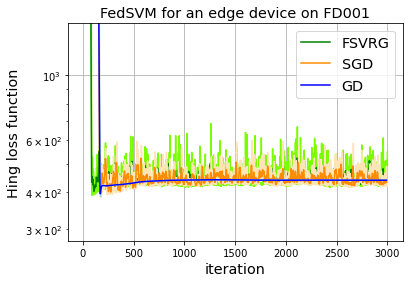

In [72]:
########################################################################################################################
########################################################################################################################
########################################################################################################################
# plot costs
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
plt.plot(cost_FSVRG, 'lawngreen')
plt.plot(running_mean(cost_FSVRG, 10), 'g', label="FSVRG")
plt.plot(cost_SGD, 'moccasin')
plt.plot(running_mean(cost_SGD, 10), 'darkorange', label="SGD")
plt.plot(cost_GD, 'lightblue')
plt.plot(running_mean(cost_GD, 10), 'b', label="GD")
plt.legend(loc="best", fontsize="x-large")
plt.yscale('log')
plt.title("FedSVM for an edge device on FD001", fontsize="x-large")
plt.ylabel("Hing loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
plt.ylim(0, 1500)
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD001/Results/"

plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("Hing loss function in FedSVM with 10 machines1 FD001.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("Hing loss function in FedSVM with 10 machines1 FD001.png", format='png', dpi=1200, bbox_inches='tight')


C:\Users\alibei\AppData\Local\Temp/ipykernel_13788/1280413748.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


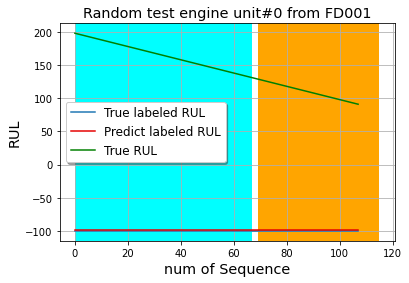

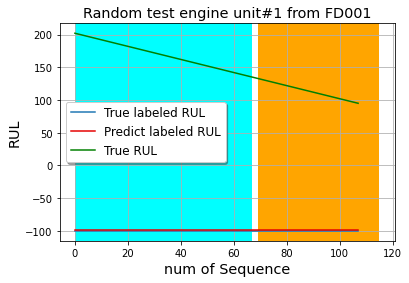

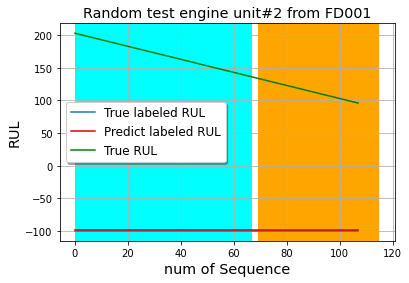

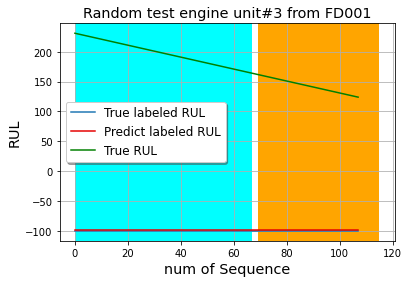

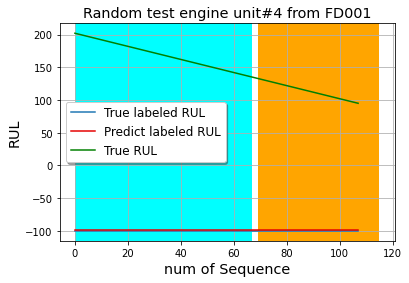

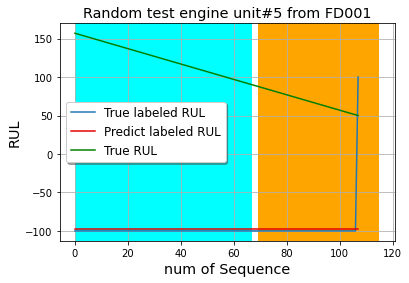

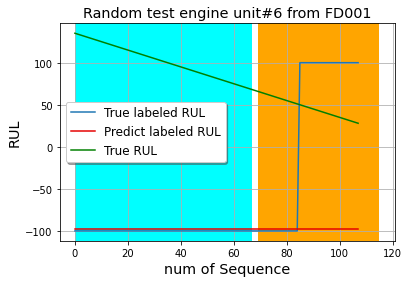

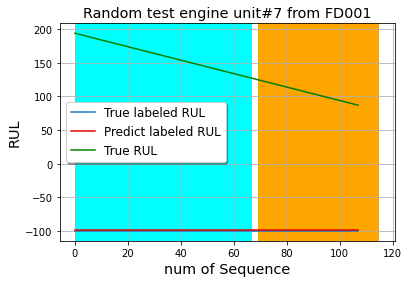

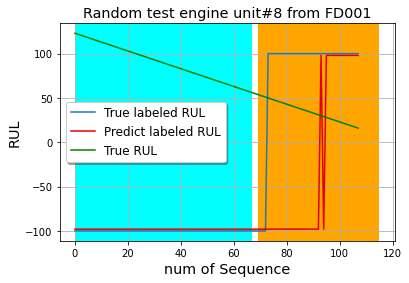

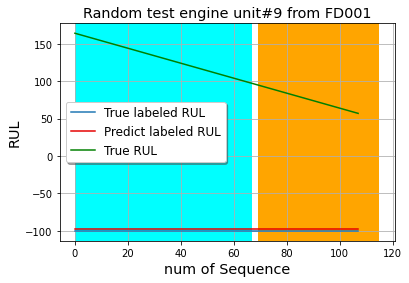

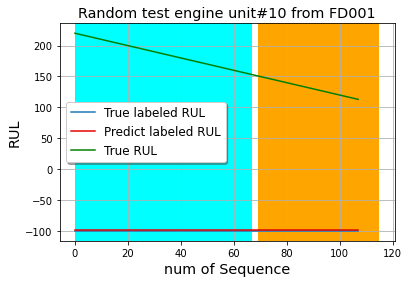

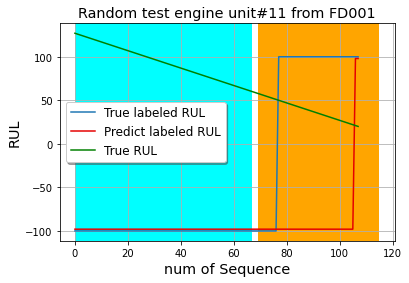

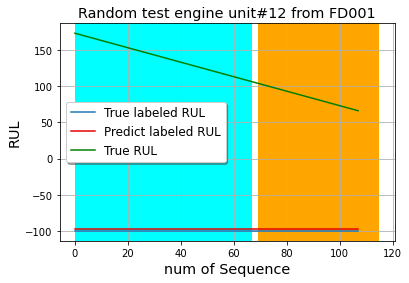

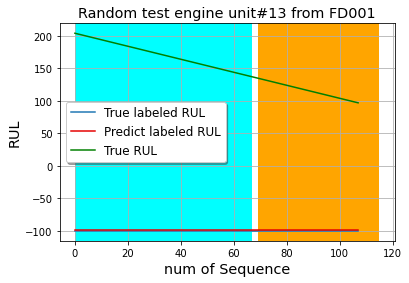

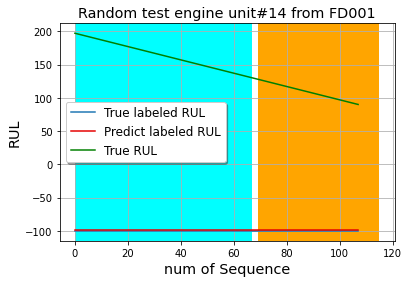

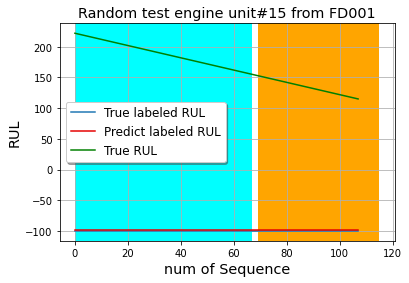

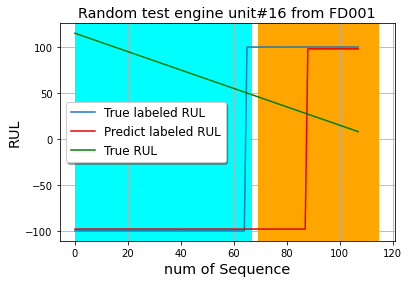

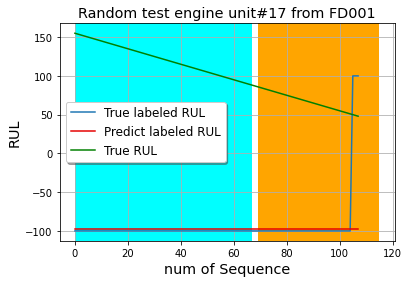

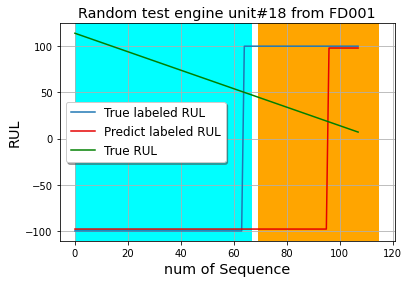

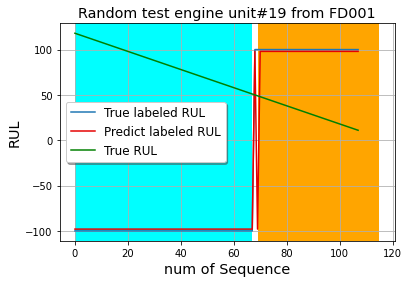

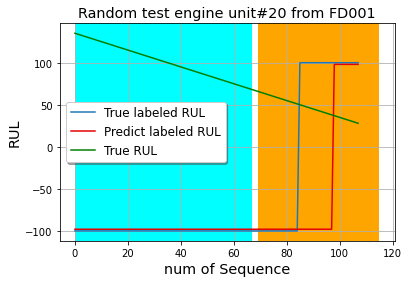

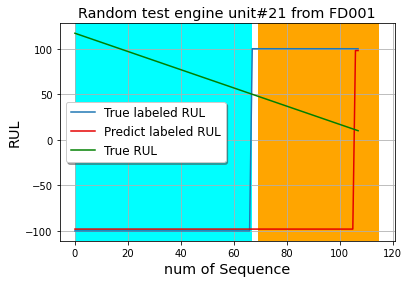

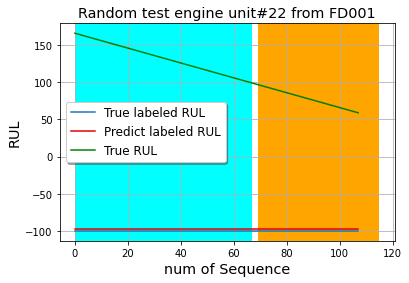

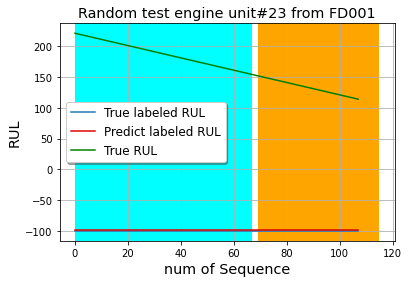

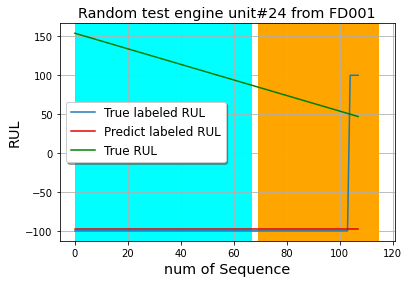

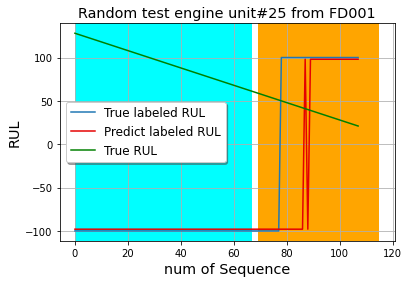

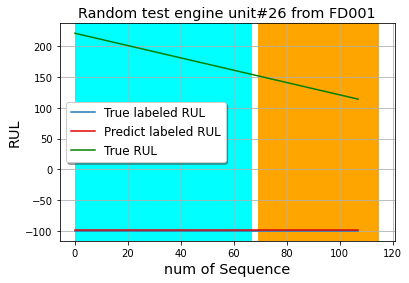

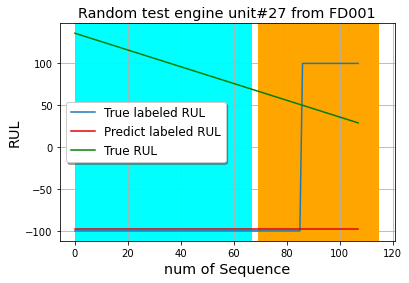

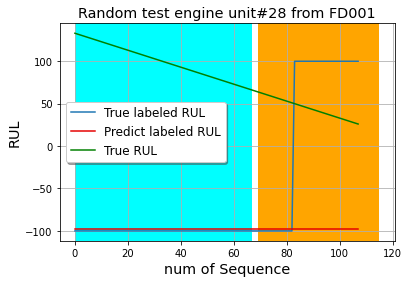

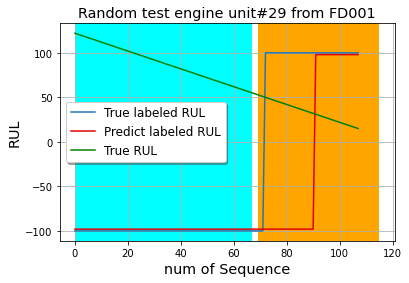

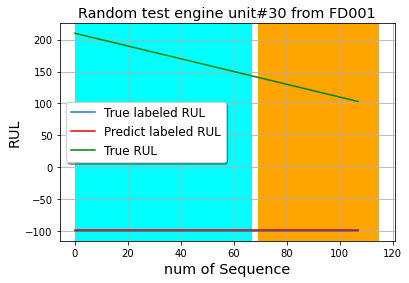

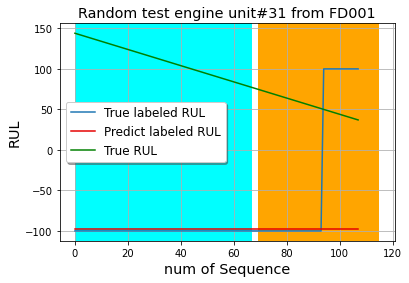

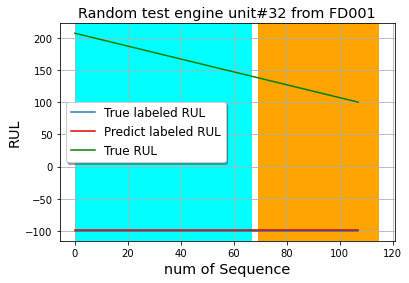

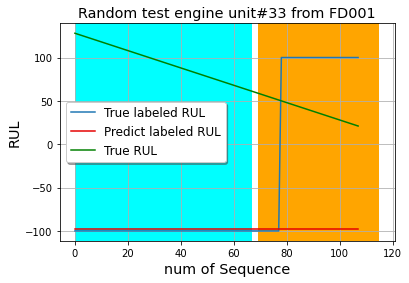

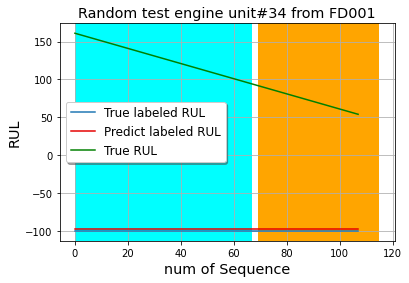

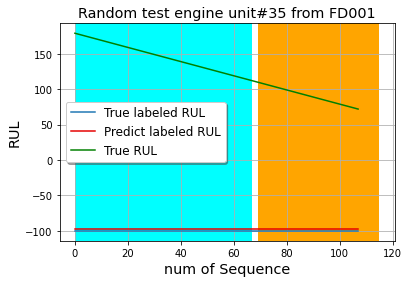

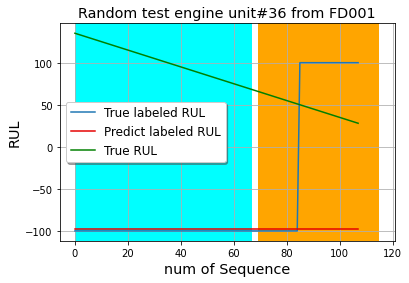

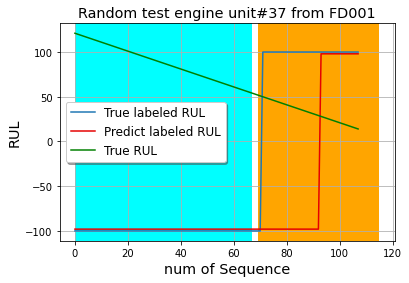

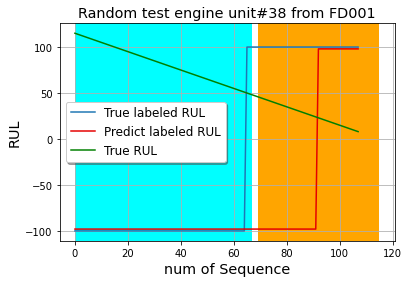

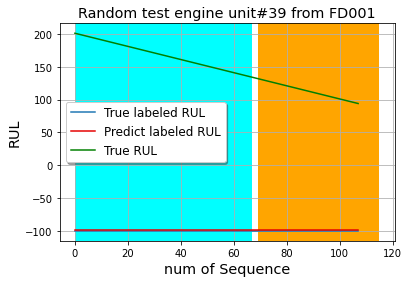

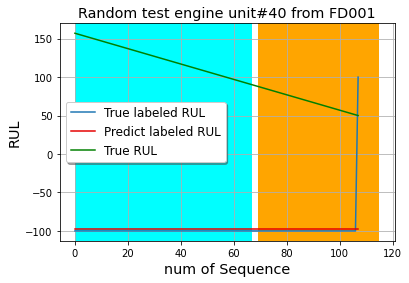

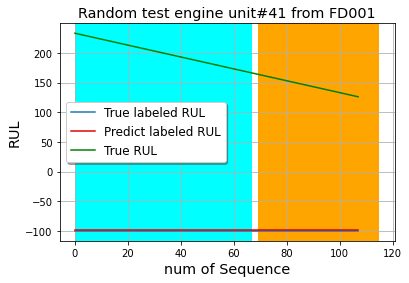

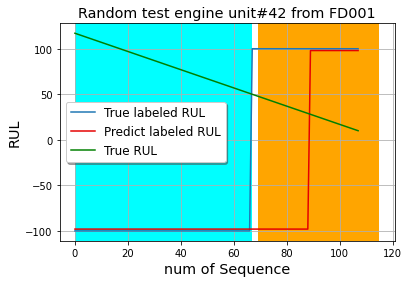

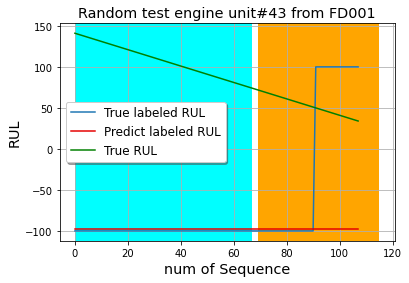

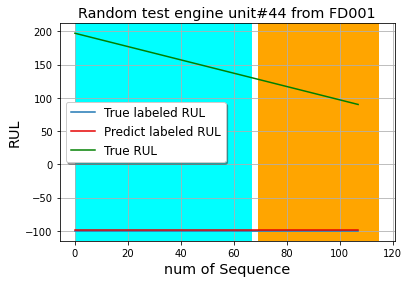

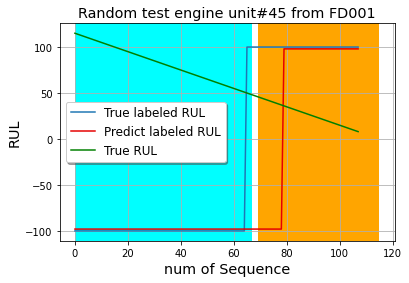

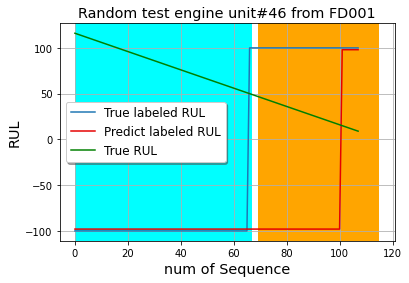

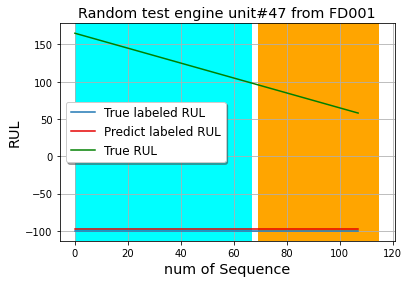

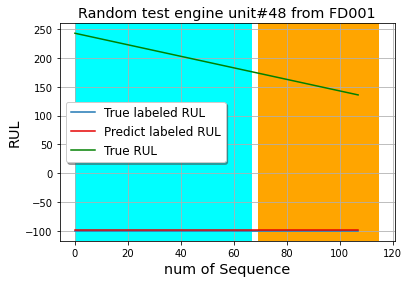

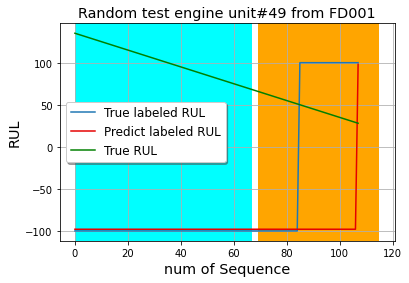

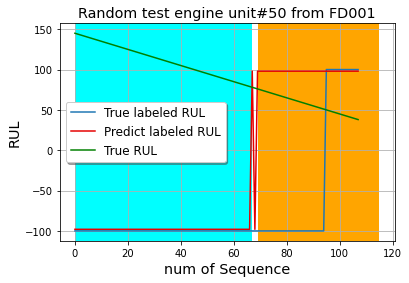

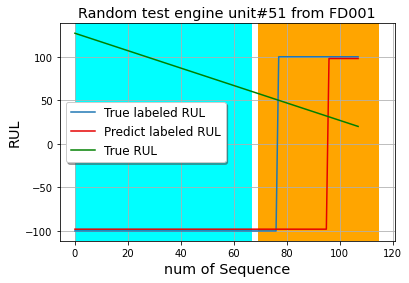

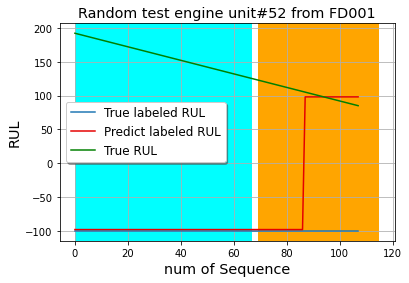

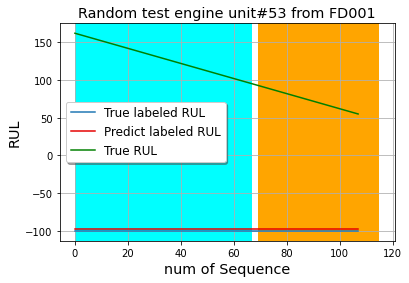

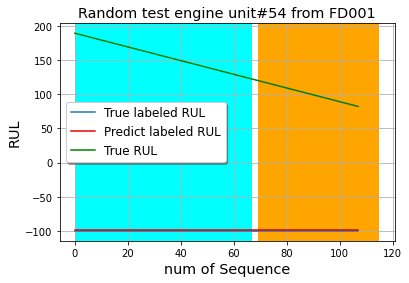

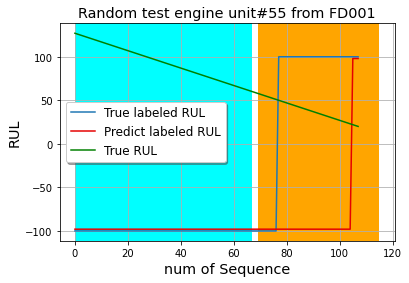

In [79]:
# Plot all the labels estimation with FedSVM for 100 master workers
fig = {}
ax = {}
for i in range(len(X_test_dic)):
    pre = predict(w_out_FSVRG, X_test_dic[i])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_test_dic[i] * 100, label='True labeled RUL')
    ax[i].plot(pre * 98, label='Predict labeled RUL', color='#E50000')
    ax[i].plot(Y_test_rul_dic[i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD001", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    #plt.xlabel("num of Sequence generated by windowing on input dataset", fontsize="x-large")
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].legend(shadow=True, fontsize='large')
    ax[i].grid()
    ax[i].axvspan(69, 115, facecolor='#FFA500')
    ax[i].axvspan(0, 67, facecolor='#00FFFF')

dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD001/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
#for i in range(len(X_test_dic)):
#    fig[i].savefig("FD001 Label prediction with FedSVM for machine number_" + str(i) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
#    fig[i].savefig("FD001 Label prediction with FedSVM for machine number_" + str(i) + ".png", format='png', dpi=1200, bbox_inches='tight')

In [80]:
# Save Specific figures
dir_name = "H:/.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/" \
           "DML_Turbofan/Python/Notebook/Results/FedSVM/master_worker/FD001/Results/Lable prediction/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[19].savefig("FD001 Label prediction with FedSVM for machine number_" + str(19) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[19].savefig("FD001 Label prediction with FedSVM for machine number_" + str(19) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
